<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_single_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Single Stock Trading

Tutorials to use OpenAI DRL to trade single stock in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: 
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues



## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4.Evaluate Algorithms and Models](#4)        
    * [4.1. Defining the Environment](#4.1)
    * [4.2. Agent Script](#4.2)
    * [4.3. Training the model](#4.3)       
* [5.Testing the Model](#5)           

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: single stock trading for AAPL


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.

We use Apple Inc. stock: AAPL as an example throughout this article, because it is one of the most popular and profitable stocks.

<a id='1'></a>
# Part 2. Getting Started- Loading the data and python packages


<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-uj5necan
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-uj5necan
     |████████████████████████████████| 6.6MB 7.0MB/s 
     |████████████████████████████████| 1.6MB 31.2MB/s 
     |████████████████████████████████| 245kB 45.3MB/s 
     |████████████████████████████████| 110.5MB 86kB/s 
     |████████████████████████████████| 307kB 41.8MB/s 
     |████████████████████████████████| 12.4MB 46.1MB/s 
     |████████████████████████████████| 256kB 46.4MB/s 
     |████████████████████████████████| 583kB 35.0MB/s 
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-5iu41rpp/pyfolio
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-5iu41rpp/pyfolio
     |████████████████████████████████| 5.5MB 43.9MB/s 
     |████████████████████████████████| 1.0MB 26.9MB/s 
     |████████████████████████████████| 


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

In [2]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4


<a id='1.3'></a>
## 2.3. Import Packages

In [23]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.environment import EnvSetup
from finrl.env.EnvMultipleStock_train import StockEnvTrain
from finrl.env.EnvMultipleStock_trade import StockEnvTrade
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot



In [4]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='1.4'></a>
## 2.4. Create Folders

In [5]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [7]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [8]:
# from config.py end_date is a string
config.END_DATE

'2020-09-30'

ticker_list is a list of stock tickers, in a single stock trading case, the list contains only 1 ticker

In [6]:
# Download and save the data in a pandas DataFrame:
data_df = YahooDownloader(start_date = config.START_DATE,
                          end_date = config.END_DATE,
                          ticker_list = ['AAPL']).fetch_data()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2956, 7)


In [10]:
data_df.shape

(2956, 7)

In [11]:
data_df.head()

,date,open,high,low,close,volume,tic
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200,AAPL
1,2009-01-05,3.327500,3.435000,3.311071,2.890248,1181608400,AAPL
2,2009-01-06,3.426786,3.470357,3.299643,2.842576,1289310400,AAPL
3,2009-01-07,3.278929,3.303571,3.223572,2.781153,753048800,AAPL
4,2009-01-08,3.229643,3.326786,3.215714,2.832797,673500800,AAPL


<a id='3'></a>
# Part 4. Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* FinRL uses a class **FeatureEngineer** to preprocess the data
* Add **technical indicators**. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc.


class FeatureEngineer:
Provides methods for preprocessing the stock price data

    Attributes
    ----------
        df: DataFrame
            data downloaded from Yahoo API
        feature_number : int
            number of features we used
        use_technical_indicator : boolean
            we technical indicator or not
        use_turbulence : boolean
            use turbulence index or not

    Methods
    -------
    preprocess_data()
        main method to do the feature engineering

## 4.1 Technical Indicators
* FinRL uses stockstats to calcualte technical indicators such as **Moving Average Convergence Divergence (MACD)**, **Relative Strength Index (RSI)**, **Average Directional Index (ADX)**, **Commodity Channel Index (CCI)** and other various indicators and stats.
* **stockstats**: supplies a wrapper StockDataFrame based on the **pandas.DataFrame** with inline stock statistics/indicators support.



In [13]:
## we store the stockstats technical indicator column names in config.py
## check https://pypi.org/project/stockstats/ for different names
config.TECHNICAL_INDICATORS_LIST

['macd', 'rsi_30', 'cci_30', 'dx_30']

## 4.2 Perform Feature Engineering

In [7]:
data_df = FeatureEngineer(data_df,
                          feature_number=5,
                          use_technical_indicator=True,
                          use_turbulence=False).preprocess_data()

Successfully added technical indicators


In [59]:
data_df.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200,AAPL,0.000000,100.000000,66.666667,100.000000
1,2009-01-05,3.327500,3.435000,3.311071,2.890248,1181608400,AAPL,0.002626,100.000000,66.666667,100.000000
2,2009-01-06,3.426786,3.470357,3.299643,2.842576,1289310400,AAPL,0.001868,70.355256,46.810872,100.000000
3,2009-01-07,3.278929,3.303571,3.223572,2.781153,753048800,AAPL,-0.000741,50.429273,-29.735567,43.608349
4,2009-01-08,3.229643,3.326786,3.215714,2.832797,673500800,AAPL,-0.000087,60.227005,-9.052599,48.358256


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## 5.1 Training & Trade data split
* Training: 2009-01-01 to 2018-12-31
* Trade: 2019-01-01 to 2020-09-30

In [8]:
train = data_split(data_df, start = config.START_DATE, end = config.START_TRADE_DATE)
trade = data_split(data_df, start = config.START_TRADE_DATE, end = config.END_DATE)
#train = data_split(data_df, start = '2009-01-01', end = '2019-01-01')
#trade = data_split(data_df, start = '2019-01-01', end = '2020-09-30')


## 5.2 User-defined Environment: a simulation environment class 

In [11]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

class SingleStockEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold,
                day = 0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = -1, high = 1,shape = (self.action_space,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (self.state_space,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold        
        # initalize state
        self.state = [self.initial_amount] + \
                      [self.data.close] + \
                      [0]*self.stock_dim  + \
                      sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
        # initialize reward
        self.reward = 0
        self.cost = 0
        # memorize all the total balance change
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self.data.date]
        self.trades = 0
        #self.reset()
        self._seed()


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+self.stock_dim+1] > 0:
            #update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * \
             (1- self.transaction_cost_pct)

            self.state[index+self.stock_dim+1] -= min(abs(action), self.state[index+self.stock_dim+1])
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+self.stock_dim+1]) * \
             self.transaction_cost_pct
            self.trades+=1
        else:
            pass

    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        # print('available_amount:{}'.format(available_amount))

        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ self.transaction_cost_pct)

        self.state[index+self.stock_dim+1] += min(available_amount, action)

        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          self.transaction_cost_pct
        self.trades+=1
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            #plt.plot(self.asset_memory,'r')
            #plt.savefig('results/account_value_train.png')
            #plt.close()
            end_total_asset = self.state[0]+ \
                sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))

            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(end_total_asset))
            df_total_value = pd.DataFrame(self.asset_memory)
            #df_total_value.to_csv('results/account_value_train.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))- self.initial_amount ))
            print("total_cost: ", self.cost)
            print("total_trades: ", self.trades)
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            if df_total_value['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                    df_total_value['daily_return'].std()
              print("Sharpe: ",sharpe)
              print("=================================")
            df_rewards = pd.DataFrame(self.rewards_memory)
            #df_rewards.to_csv('results/account_rewards_train.csv')
            
            # print('total asset: {}'.format(self.state[0]+ sum(np.array(self.state[1:29])*np.array(self.state[29:]))))
            #with open('obs.pkl', 'wb') as f:  
            #    pickle.dump(self.state, f)
            
            return self.state, self.reward, self.terminal,{}

        else:
            # print(np.array(self.state[1:29]))
            self.date_memory.append(self.data.date)
            self.actions_memory.append(actions)

            actions = actions * self.hmax
            #actions = (actions.astype(int))
            
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    [self.data.close] + \
                    list(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]) + \
                      sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(self.stock_dim+1)])*np.array(self.state[(self.stock_dim+1):(self.stock_dim*2+1)]))
            self.asset_memory.append(end_total_asset)
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset            
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward*self.reward_scaling



        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        self.actions_memory=[]
        self.date_memory=[self.data.date]
        #initiate state
        self.state = [self.initial_amount] + \
                      [self.data.close] + \
                      [0]*self.stock_dim + \
                      sum([[self.data[tech]] for tech in self.tech_indicator_list ], [])
        # iteration += 1 
        return self.state
    
    def render(self, mode='human'):
        return self.state
    
    def save_asset_memory(self):
        date_list = self.date_memory
        asset_list = self.asset_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'account_value':asset_list})
        return df_account_value

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

## 5.3 Initialize Environment
* **stock dimension**: the number of unique stock tickers we use
* **hmax**: the maximum amount of shares to buy or sell
* **initial amount**: the amount of money we use to trade in the begining
* **transaction cost percentage**: a per share rate for every share trade

In [12]:
env_setup = EnvSetup(stock_dim = len(train.tic.unique()),
                     hmax = 200,
                     initial_amount = 100000,
                     transaction_cost_pct = 0.001)

In [34]:
# the stock dimension is 1, because we only use the price data of AAPL.
len(train.tic.unique())

1

In [13]:
env_train = env_setup.create_env_training(data = train,
                                          env_class = SingleStockEnv)

In [36]:
train.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30
0,2009-01-02,3.067143,3.251429,3.041429,2.773207,746015200,AAPL,0.000000,100.000000,66.666667,100.000000
1,2009-01-05,3.327500,3.435000,3.311071,2.890248,1181608400,AAPL,0.002626,100.000000,66.666667,100.000000
2,2009-01-06,3.426786,3.470357,3.299643,2.842576,1289310400,AAPL,0.001868,70.355256,46.810872,100.000000
3,2009-01-07,3.278929,3.303571,3.223572,2.781153,753048800,AAPL,-0.000741,50.429273,-29.735567,43.608349
4,2009-01-08,3.229643,3.326786,3.215714,2.832797,673500800,AAPL,-0.000087,60.227005,-9.052599,48.358256


# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [14]:
agent = DRLAgent(env = env_train)

### Model Training: 4 models, A2C DDPG, PPO, TD3



### Model 1: A2C

In [15]:
## default hyperparameters in config file
config.A2C_PARAMS

{'ent_coef': 0.01,
 'learning_rate': 0.0007,
 'n_steps': 5,
 'timesteps': 20000,
 'verbose': 0}

In [16]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
a2c_params_tuning = {'n_steps':5, 
			  'ent_coef':0.005, 
			  'learning_rate':0.0007,
			  'verbose':0,
			  'timesteps':100000}
model_a2c = agent.train_A2C(model_name = "A2C_{}".format(now), model_params = a2c_params_tuning)

==============Model Training===========




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


begin_total_asset:100000
end_total_asset:229853.2779368544
total_reward:129853.2779368544
total_cost:  6311.8295098708795
total_trades:  2513
Sharpe:  0.6086895609474844
begin_total_asset:100000
end_total_asset:175118.17823255586
total_reward:75118.17823255586
total_cost:  6520.200593578725
total_trades:  2476
Sharpe:  0.534303966688967
begin_total_asset:100000
end_total_asset:426319.8410604587
total_reward:326319.8410604587
total_cost:  6753.700355632277
total_trades:  2513
Sharpe:  0.8581041923542391
begin_total_asset:100000
end_total_asset:618060.8196572476
total_reward:518060.81965724763
total

### Model 2: DDPG

In [38]:
## default hyperparameters in config file
config.DDPG_PARAMS

{'batch_size': 128, 'buffer_size': 50000, 'timesteps': 20000, 'verbose': 0}

In [39]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ddpg_params_tuning = {
                     'batch_size': 128,
			               'buffer_size':100000, 
			               'verbose':0,
			               'timesteps':50000}
model_ddpg = agent.train_DDPG(model_name = "DDPG_{}".format(now), model_params = ddpg_params_tuning)

==============Model Training===========
begin_total_asset:100000
end_total_asset:823421.1824645727
total_reward:723421.1824645727
total_cost:  750.3913353938693
total_trades:  2515
Sharpe:  0.9760728102010648
begin_total_asset:100000
end_total_asset:302447.47331547324
total_reward:202447.47331547324
total_cost:  1421.3721174964785
total_trades:  1913
Sharpe:  0.7081524695528527
begin_total_asset:100000
end_total_asset:1059649.3357651094
total_reward:959649.3357651094
total_cost:  507.2272558992455
total_trades:  2512
Sharpe:  1.0640922593890412
begin_total_asset:100000
end_total_asset:1049327.2068946387
total_reward:949327.2068946387
total_cost:  496.12038073796066
total_trades:  2512
Sharpe:  1.0617193164707417
begin_total_asset:100000
end_total_asset:695239.8589412506
total_reward:595239.8589412506
total_cost:  1884.732178113722
total_trades:  2515
Sharpe:  0.9455338839495788
begin_total_asset:100000
end_total_asset:1057240.9178244558
total_reward:957240.9178244558
total_cost:  782.3

### Model 3: PPO

In [56]:
config.PPO_PARAMS

{'ent_coef': 0.01,
 'learning_rate': 0.00025,
 'n_steps': 128,
 'nminibatches': 4,
 'timesteps': 20000,
 'verbose': 0}

In [57]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
ppo_params_tuning = {'n_steps':128, 
                     'nminibatches': 4,
			               'ent_coef':0.005, 
			               'learning_rate':0.00025,
			              'verbose':0,
			              'timesteps':100000}
model_ppo = agent.train_PPO(model_name = "PPO_{}".format(now), model_params = ppo_params_tuning)

==============Model Training===========

begin_total_asset:100000
end_total_asset:247581.054150193
total_reward:147581.054150193
total_cost:  6311.2929698310545
total_trades:  2496
Sharpe:  0.6611389053179111
begin_total_asset:100000
end_total_asset:666508.8440723165
total_reward:566508.8440723165
total_cost:  4982.43199591024
total_trades:  2515
Sharpe:  0.9186822836502746
begin_total_asset:100000
end_total_asset:819678.2016003594
total_reward:719678.2016003594
total_cost:  3262.5618693676074
total_trades:  2515
Sharpe:  0.980245396369028
begin_total_asset:100000
end_total_asset:944176.1451656532
total_reward:844176.1451656532
total_cost:  1377.6609343177051
total_trades:  2515
Sharpe:  1.0253605439589886
begin_total_asset:100000
end_total_asset:932910.4720913273
total_reward:832910.4720913273
total_cost:  533.4550272294397
total_trades:  2515
Sharpe:  1.0204968666857308
begin_total_asset:100000
end_total_asset:1000388.7641054661
total_reward:900388.7641054661
total_cost:  483.9525735

### Model 4: TD3

In [45]:
## default hyperparameters in config file
config.TD3_PARAMS

{'batch_size': 128,
 'buffer_size': 50000,
 'learning_rate': 0.0001,
 'timesteps': 20000,
 'verbose': 0}

In [46]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')
td3_params_tuning = {
                     'batch_size': 128,
			               'buffer_size':100000, 
                      'learning_rate': 0.0001,
			               'verbose':0,
			               'timesteps':50000}
model_td3 = agent.train_TD3(model_name = "TD3_{}".format(now), model_params = td3_params_tuning)

==============Model Training===========


begin_total_asset:100000
end_total_asset:760874.7257188869
total_reward:660874.7257188869
total_cost:  377.3784457784614
total_trades:  2502
Sharpe:  0.9455074160252377
begin_total_asset:100000
end_total_asset:1064588.0090034064
total_reward:964588.0090034064
total_cost:  99.89905300877778
total_trades:  2515
Sharpe:  1.0656172198033842
begin_total_asset:100000
end_total_asset:1062555.7576902194
total_reward:962555.7576902194
total_cost:  99.89623975029548
total_trades:  2515
Sharpe:  1.064987709515692
begin_total_asset:100000
end_total_asset:1064466.2504255872
total_reward:964466.2504255872
total_cost:  99.895599606372
total_trades:  2515
Sharpe:  1.0655886472365244
begin_total_asset:100000
end_total_asset:1068761.0722142984
total_reward:968761.0722142984
total_cost:  99.89736491668042
total_trades:  2515
Sharpe:  1.066955388936271
begin_total_asset:100000
end_total_asset:1066839.0525923532
total_reward:966839.0525923532
total_cost:  99.898562

### Trading
* we use the environment class we initialized at 5.3 to create a stock trading environment
* Assume that we have $100,000 initial capital at 2019-01-01. 
* We use the TD3 trained model to trade AAPL.

In [17]:
trade.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30
0,2019-01-02,38.722500,39.712502,38.557499,38.249401,148158800,AAPL,-2.003499,37.867367,-91.588048,42.250808
1,2019-01-03,35.994999,36.430000,35.500000,34.439476,365248800,AAPL,-2.185138,32.751929,-177.947711,55.246973
2,2019-01-04,36.132500,37.137501,35.950001,35.909672,234428400,AAPL,-2.185265,36.192807,-139.741311,47.060632
3,2019-01-07,37.174999,37.207500,36.474998,35.829746,219111200,AAPL,-2.166837,36.088959,-122.749871,46.245025
4,2019-01-08,37.389999,37.955002,37.130001,36.512772,164101200,AAPL,-2.073220,37.670014,-95.018705,37.537680


In [18]:
# create trading env
env_trade, obs_trade = env_setup.create_env_trading(data = trade,
                                                    env_class = SingleStockEnv) 


In [20]:
## make a prediction and get the account value change
df_account_value = DRLAgent.DRL_prediction(model=model_a2c,
                        test_data = trade,
                        test_env = env_trade,
                        test_obs = obs_trade)

begin_total_asset:100000
end_total_asset:291352.9025439278
total_reward:191352.90254392778
total_cost:  5676.363341531593
total_trades:  439
Sharpe:  1.905471942346013


# Part 5: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

## 5.1 BackTestStats

In [21]:
print("==============Get Backtest Results===========")
perf_stats_all = BackTestStats(df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
annual return:  96.74655549243907
sharpe ratio:  1.905471942346013
Annual return          0.844954
Cumulative returns     1.913529
Annual volatility      0.355637
Sharpe ratio           1.905472
Calmar ratio           2.824309
Stability              0.909370
Max drawdown          -0.299172
Omega ratio            1.437170
Sortino ratio          2.902786
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.065603
Daily value at risk   -0.042117
Alpha                  0.000000
Beta                   1.000000
dtype: float64


## 5.2 BackTestPlot

==============Compare to AAPL itself buy-and-hold===========
annual return:  96.74655549243907
sharpe ratio:  1.905471942346013
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)


Start date,2019-01-03
End date,2020-09-29
Total months,20
,Backtest
Annual return,84.753%
Cumulative returns,191.353%
Annual volatility,35.564%
Sharpe ratio,1.91
Calmar ratio,2.83
Stability,0.91
Max drawdown,-29.917%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.92,2020-02-12,2020-03-23,2020-06-01,79
1,19.08,2020-09-01,2020-09-18,NaT,NaN
2,17.11,2019-05-03,2019-06-03,2019-07-31,64
3,8.71,2019-07-31,2019-08-05,2019-08-21,16
4,5.40,2020-07-20,2020-07-24,2020-07-31,10


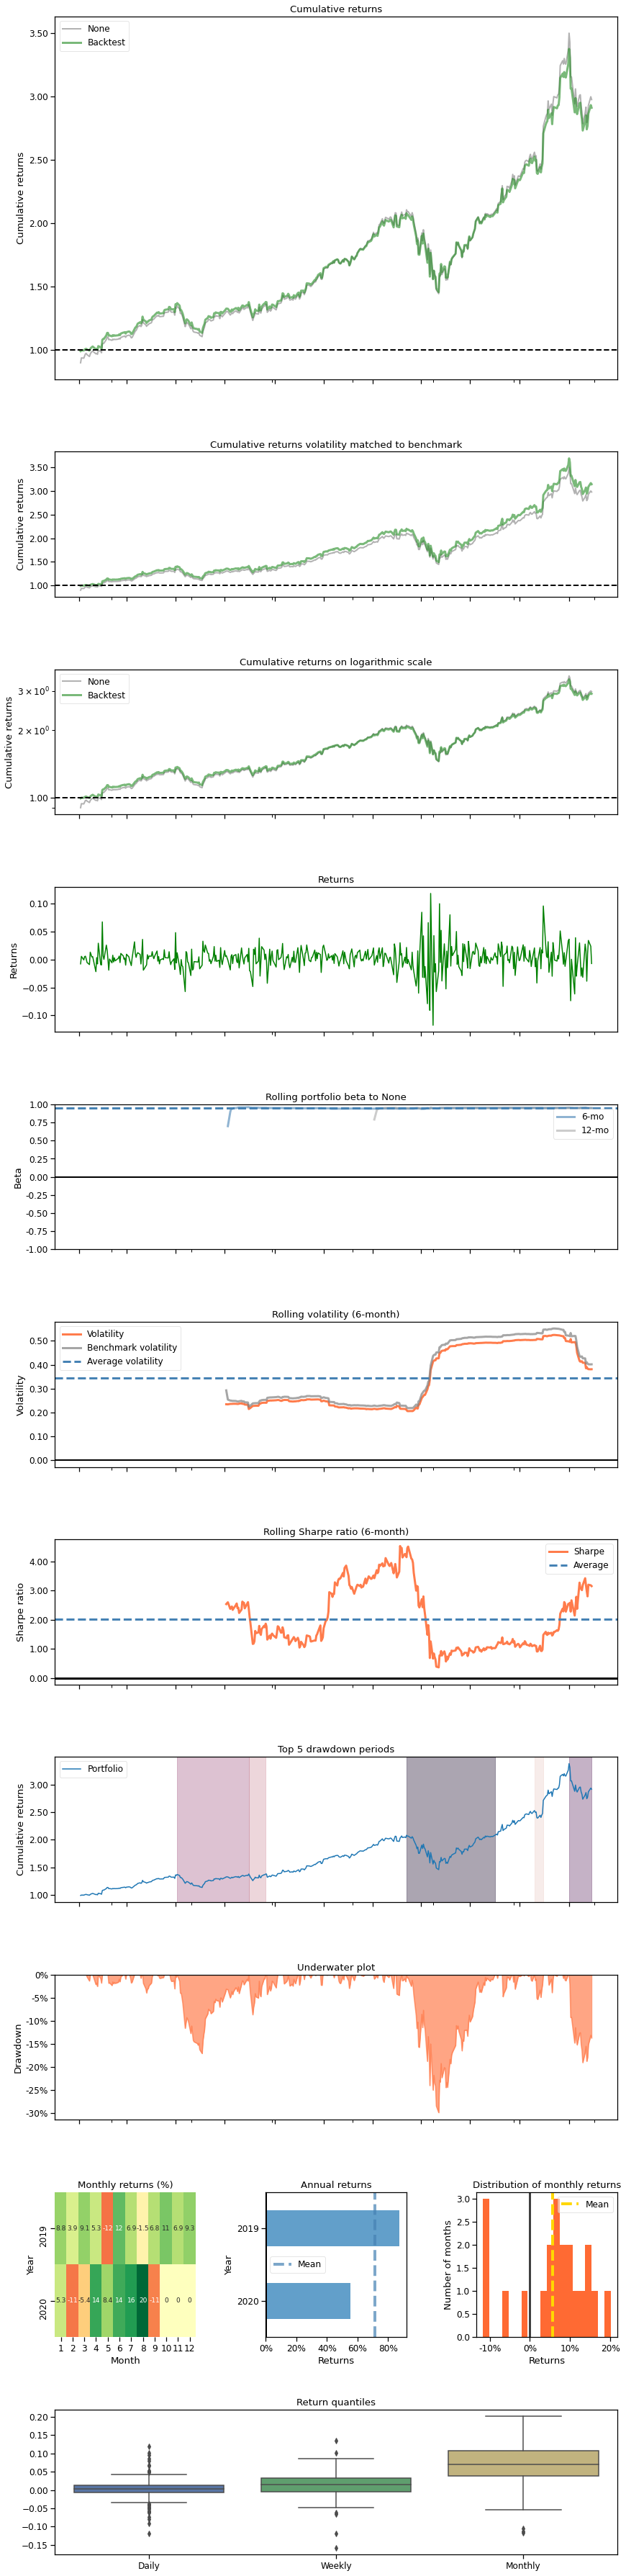

In [27]:
print("==============Compare to AAPL itself buy-and-hold===========")
%matplotlib inline
BackTestPlot(df_account_value, baseline_ticker = 'AAPL')

## 5.3 Baseline Stats

In [24]:
print("==============Get Baseline Stats===========")
BaselineStats('AAPL')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)
Annual return          0.868103
Cumulative returns     1.977654
Annual volatility      0.384009
Sharpe ratio           1.825350
Calmar ratio           2.762260
Stability              0.909223
Max drawdown          -0.314273
Omega ratio            1.416301
Sortino ratio          2.709220
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.067808
Daily value at risk   -0.045599
Alpha                  0.000000
Beta                   1.000000
dtype: float64


Annual return          0.868103
Cumulative returns     1.977654
Annual volatility      0.384009
Sharpe ratio           1.825350
Calmar ratio           2.762260
Stability              0.909223
Max drawdown          -0.314273
Omega ratio            1.416301
Sortino ratio          2.709220
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.067808
Daily value at risk   -0.045599
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [29]:
print("==============Get Baseline Stats===========")
BaselineStats('^GSPC')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)
Annual return          0.176845
Cumulative returns     0.328857
Annual volatility      0.270644
Sharpe ratio           0.739474
Calmar ratio           0.521283
Stability              0.339596
Max drawdown          -0.339250
Omega ratio            1.174869
Sortino ratio          1.015508
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.659621
Daily value at risk   -0.033304
Alpha                  0.000000
Beta                   1.000000
dtype: float64


Annual return          0.176845
Cumulative returns     0.328857
Annual volatility      0.270644
Sharpe ratio           0.739474
Calmar ratio           0.521283
Stability              0.339596
Max drawdown          -0.339250
Omega ratio            1.174869
Sortino ratio          1.015508
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.659621
Daily value at risk   -0.033304
Alpha                  0.000000
Beta                   1.000000
dtype: float64

## 5.4 Compare to Stock Market Index

annual return:  96.74655549243907
sharpe ratio:  1.905471942346013
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)


Start date,2019-01-03
End date,2020-09-29
Total months,20
,Backtest
Annual return,84.753%
Cumulative returns,191.353%
Annual volatility,35.564%
Sharpe ratio,1.91
Calmar ratio,2.83
Stability,0.91
Max drawdown,-29.917%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.92,2020-02-12,2020-03-23,2020-06-01,79
1,19.08,2020-09-01,2020-09-18,NaT,NaN
2,17.11,2019-05-03,2019-06-03,2019-07-31,64
3,8.71,2019-07-31,2019-08-05,2019-08-21,16
4,5.40,2020-07-20,2020-07-24,2020-07-31,10


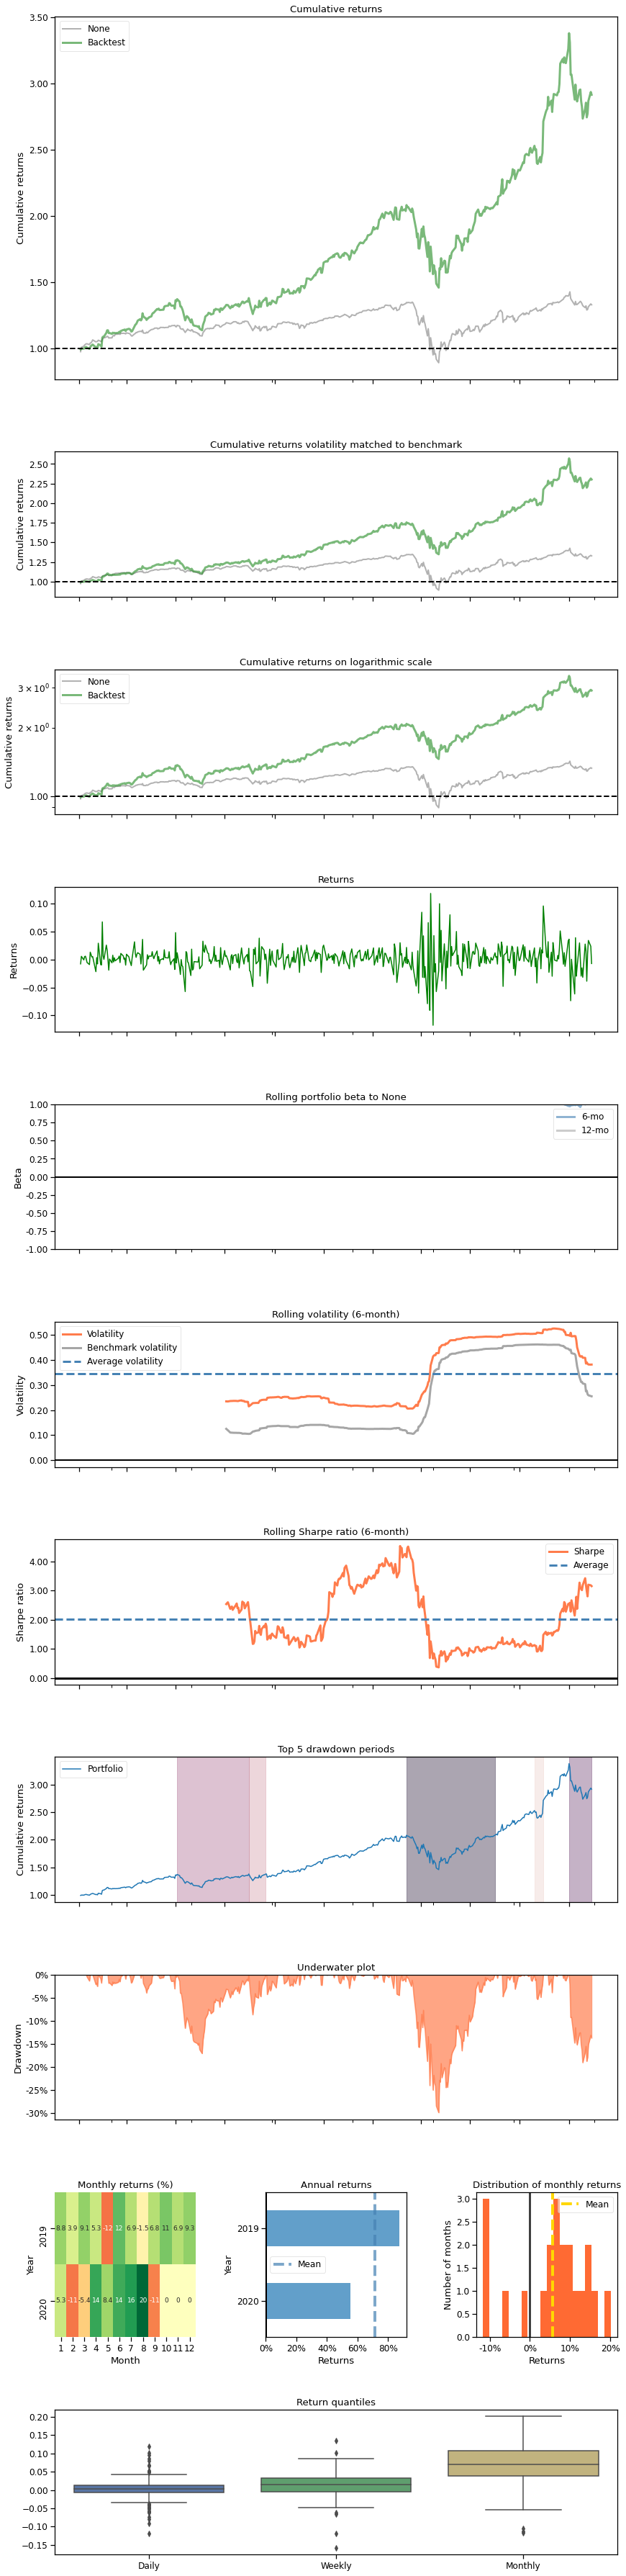

In [25]:
print("==============Compare to S&P 500===========")
%matplotlib inline
BackTestPlot(df_account_value, baseline_ticker = '^GSPC')

annual return:  96.74655549243907
sharpe ratio:  1.905471942346013
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (440, 7)


Start date,2019-01-03
End date,2020-09-29
Total months,20
,Backtest
Annual return,84.753%
Cumulative returns,191.353%
Annual volatility,35.564%
Sharpe ratio,1.91
Calmar ratio,2.83
Stability,0.91
Max drawdown,-29.917%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.92,2020-02-12,2020-03-23,2020-06-01,79
1,19.08,2020-09-01,2020-09-18,NaT,NaN
2,17.11,2019-05-03,2019-06-03,2019-07-31,64
3,8.71,2019-07-31,2019-08-05,2019-08-21,16
4,5.40,2020-07-20,2020-07-24,2020-07-31,10


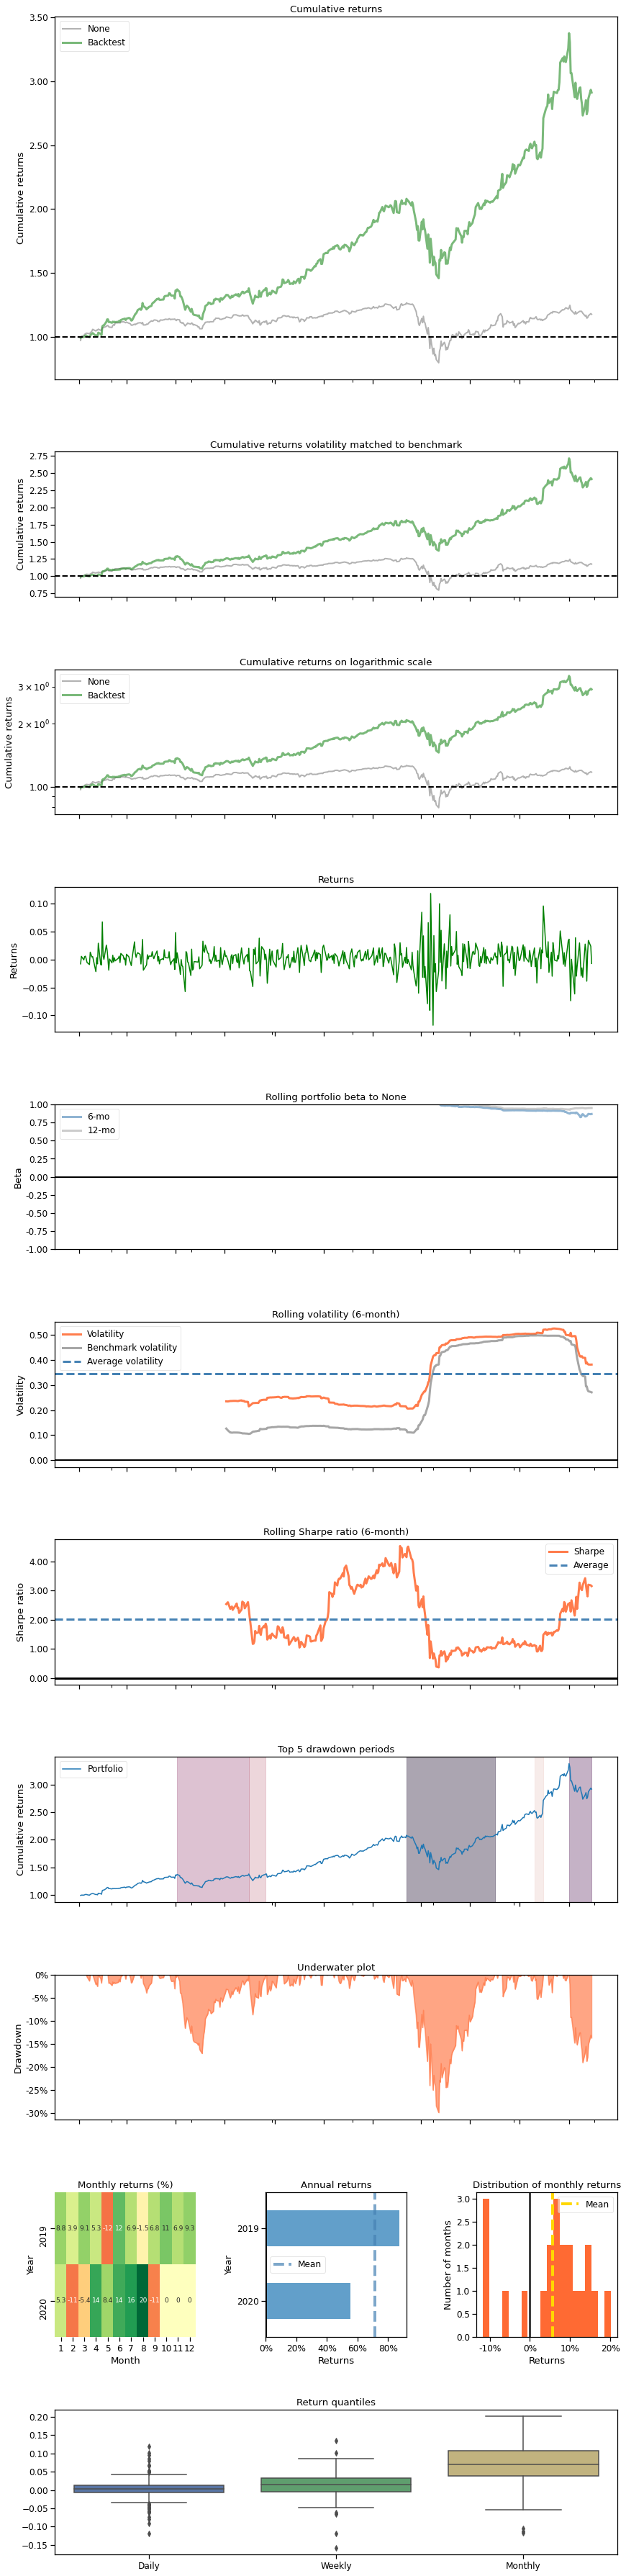

In [26]:
print("==============Compare to Dow Jones===========")
%matplotlib inline
BackTestPlot(df_account_value, baseline_ticker = '^DJI')